# Transfering knowledge through finetuning 

In previous chapters, 
we demonstrated how to train a neural network 
to recognize the categories corresponding to objects in images.
We looked at toy datasets like hand-written digits,
and thumbnail-sized pictures of animals. 
And we talked about the ImageNet dataset, 
the default academic benchmark,
which contains 1M million images,
1000 each from 1000 separate classes.

The ImageNet dataset categorically changed what was possible in computer vision.
It turns out some things are possible (these days, even easy) 
on gigantic datasets, that simply aren't with smaller datasets.
In fact, we don't know of any technique that can comparably powerful model
on a similar photograph dataset but containing only, say, 10k images.

And that's a problem. 
Because however impressive the results of CNNs on ImageNet may be,
most people aren't interested in ImageNet itself.
They're interested in their own problems.
Recognize people based on pictures of their faces.
Distinguish between photographs of $10$ different types of coral on the ocean floor. 
Usually when individuals (and not Amazon, Google, or inter-institutional *big science* initiatives)
are interested in solving a computer vision problem,
they come to the table with modestly sized datasets. 
A few hundred examples may be common and a few thousand examples may be as much as you can reasonably ask for.

So one natural question emerges.
Can we somehow use the powerful models trained on millions of examples for one dataset,
and apply them to improve performance on a new problem 
with a much smaller dataset?
This kind of problem (learning on source dataset, bringing knowledge to target dataset),
is appropriately called *transfer learning*. 
Fortunately, we have some effective tools for solving this problem.

For deep neural networks, the most popular approach is called finetuning
and the idea is both simple and effective:

* Train a neural network on the source task $S$.
* Decapitate it, replacing it's output layer appropriate to target task $T$.
* Initialize the weights on the new output layer randomly, keeping all other (pretrained) weights the same.
* Begin training on the new dataset.

This might be clearer if we visualize the algorithm: 

![](../img/fine-tune.png)


In this section, we'll demonstrate fine-tuning,
using the popular and compact SqueezeNet architecture.
Since we don't want to saddle you with the burden of downloading ImageNet,
or of training on ImageNet from scratch,
we'll pull the weights of the pretrained Squeeze net from the internet.
Specifically, we'll be fine-tuning a squeezenet-1.1 
that was pre-trained on imagenet-12.
Finally, we'll fine-tune it to recognize **hotdogs**.

We'll start with the obligatory ritual of importing a bunch of stuff that you'll need later. 

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


## Settings
We'll set a few settings up here that you can configure later to manipulate the behavior of the algorithm. 
These are mostly familiar. 
Hybrid mode, uses the just in time compiler described in [our chapter on high performance training](../chapter07_distributed-learning/hybridize.ipynb)
to make the network much faster to train. 
Since we're not working with any crazy dynamic graphs that can't be compiled, 
there's no reason not to hybridize. 
The batch size, number of training epochs, weight decay, and learing rate should all be familiar by now.
The positive class weight, says how much more we should upweight the importance of positive instances (photos of hot dogs) in the objective function. 
We use this to combat the extreme class imbalance (not surprisingly, most pictures do not depict hot dogs). 

In [4]:

# Demo mode uses the validation dataset for training, which is smaller and faster to train.
demo = True
log_interval = 100
gpus = 0

# Options are imperative or hybrid. Use hybrid for better performance.
mode = 'hybrid'

# training hyperparameters
batch_size = 2 # use bigger e.g. 256 for big machines
if demo:
    epochs = 5
    learning_rate = 0.02
    wd = 0.002
else:
    epochs = 40
    learning_rate = 0.05
    wd = 0.002

# the class weight for hotdog class to help the imbalance problem.
positive_class_weight = 5

num_workers = 1

In [5]:

from __future__ import print_function
import logging
logging.basicConfig(level=logging.INFO)
import os
import time
from collections import OrderedDict
import skimage.io as io

import mxnet as mx
from mxnet.test_utils import download
mx.random.seed(127)

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon.data.vision import transforms

import mxnet as mx
from mxnet.test_utils import download
mx.random.seed(127)

## Dataset
Formally, hot dog recognition is a binary classification problem.
We'll use $1$ to represent the hotdog class, 
and $0$ for the *not hotdog* class. 
Our hot dog dataset (the target dataset which we'll fine-tune the model to)
contains 18,141 sample images, 2091 of which are hotdogs.
Because the dataset is imbalanced (e.g. hotdog class is only 1% in mscoco dataset), 
sampling interesting negative samples can help to improve the performance of our algorithm. 
Thus, in the negative class in the our dataset, 
two thirds are images from food categories (e.g. pizza) other than hotdogs, 
and 30% are images from all other categories.

### Files
We prepare the dataset in the format of MXRecord using [im2rec](http://mxnet.io/how_to/recordio.html?highlight=im2rec) tool. As of the current draft, rec files are not yet explained in the book, but if you're reading after November or December 2017 and you still see this note, [open an issue on GitHub](https://github.com/zackchase/mxnet-the-straight-dope) and let us know to stop slacking off. 

- not_hotdog_train.rec 641M (1882 positive, 10000 interesting negative, and 5000 random negative)
- not_hotdog_validation.rec 49M (209 positive, 700 interesting negative, and 350 random negative)

In [6]:
"""
dataset_files = {'train': ('not_hotdog_train-e6ef27b4.rec', '0aad7e1f16f5fb109b719a414a867bbee6ef27b4'),
                 'validation': ('not_hotdog_validation-c0201740.rec', '723ae5f8a433ed2e2bf729baec6b878ac0201740')}
                 """


"\ndataset_files = {'train': ('not_hotdog_train-e6ef27b4.rec', '0aad7e1f16f5fb109b719a414a867bbee6ef27b4'),\n                 'validation': ('not_hotdog_validation-c0201740.rec', '723ae5f8a433ed2e2bf729baec6b878ac0201740')}\n                 "

To demo the model here, we're justgoing to use the smaller validation set.
But if you're interested in training on the full set, 
set 'demo' to False in the settings at the beginning.
Now we're ready to download and verify the dataset.

In [7]:
# generate .rec file using im2rec
'''
if demo:
    training_dataset, training_data_hash = train_dataset
else:
    training_dataset, training_data_hash = train_dataset

validation_dataset, validation_data_hash = test_dataset


if demo:
    training_dataset, training_data_hash = train_dataset_files['validation']
else:
    training_dataset, training_data_hash = dataset_files['train']

validation_dataset, validation_data_hash = dataset_files['validation']

def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        logging.warn('Found hash mismatch in file {}, possibly due to incomplete download.'
                     .format(file_path))
    return matched

url_format = './train_rec.rec'
if not os.path.exists(training_dataset) or not verified(training_dataset, training_data_hash):
    logging.info('Downloading training dataset.')
    download(url_format.format(training_dataset),
             overwrite=True)
if not os.path.exists(validation_dataset) or not verified(validation_dataset, validation_data_hash):
    logging.info('Downloading validation dataset.')
    download(url_format.format(validation_dataset),
             overwrite=True)
'''

"\nif demo:\n    training_dataset, training_data_hash = train_dataset\nelse:\n    training_dataset, training_data_hash = train_dataset\n\nvalidation_dataset, validation_data_hash = test_dataset\n\n\nif demo:\n    training_dataset, training_data_hash = train_dataset_files['validation']\nelse:\n    training_dataset, training_data_hash = dataset_files['train']\n\nvalidation_dataset, validation_data_hash = dataset_files['validation']\n\ndef verified(file_path, sha1hash):\n    import hashlib\n    sha1 = hashlib.sha1()\n    with open(file_path, 'rb') as f:\n        while True:\n            data = f.read(1048576)\n            if not data:\n                break\n            sha1.update(data)\n    matched = sha1.hexdigest() == sha1hash\n    if not matched:\n        logging.warn('Found hash mismatch in file {}, possibly due to incomplete download.'\n                     .format(file_path))\n    return matched\n\nurl_format = './train_rec.rec'\nif not os.path.exists(training_dataset) or not veri

### Iterators

The record files can be read using [mx.io.ImageRecordIter](http://mxnet.io/api/python/io.html#mxnet.io.ImageRecordIter)

In [8]:
# load dataset
train_iter = mx.io.ImageRecordIter(path_imgrec="./train_rec.rec",
                                   min_img_size=256,
                                   data_shape=(3, 224, 224),
                                   rand_crop=True,
                                   shuffle=True,
                                   batch_size=batch_size,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)
val_iter = mx.io.ImageRecordIter(path_imgrec="./test_rec.rec",
                                 min_img_size=256,
                                 data_shape=(3, 224, 224),
                                 batch_size=batch_size)
                              

In [9]:
import os
from mxnet import nd
from mxnet.io import ImageRecordIter

rec_path = os.path.expanduser('./')

# You need to specify ``root`` for ImageNet if you extracted the images into
# a different folder
train_data = ImageRecordIter(
    path_imgrec = os.path.join(rec_path, 'train_rec.rec'),
    path_imgidx = os.path.join(rec_path, 'train_rec.idx'),
    data_shape  = (3, 224, 224),
    batch_size  = 32,
    shuffle     = True
)

## Model

The model we are finetuning is [SqueezeNet](https://arxiv.org/abs/1602.07360). Gluon module offers squeezenet v1.0 and v1.1 that are pretrained on ImageNet. This is just a convolutional neural network, with an architecture chosen to have a small number of parameters and to require a minimal amount of computation. It's especially popular for folks that need to run CNNs on low-powered devices like cell phones and other internet-of-things devices.

## Pulling the pre-trained model
Fortunately, MXNet has a model zoo that gives us convenient access to a number of popular models,
both their architectres and their pretrained parameters.
Let's download SqueezeNet right now with just a few lines of code.

In [10]:
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models

# get pretrained squeezenet
net = models.squeezenet1_1(pretrained=True, prefix='deep_dog_')
# hot dog happens to be a class in imagenet.
# we can reuse the weight for that class for better performance
# here's the index for that class for later use
imagenet_hotdog_index = 713

### DeepDog net

We can now use the feature extractor part from the pretrained squeezenet to build our own network. The model zoo, even handles the decaptiation for us. All we have to do is specify the number out of output classes in our new task, which we do via the keyword argument `classes=2`.

In [11]:
deep_dog_net = models.squeezenet1_1(prefix='deep_dog_', classes=2)
deep_dog_net.collect_params().initialize()
deep_dog_net.features = net.features
print(deep_dog_net)

SqueezeNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(2, 2))
    (1): Activation(relu)
    (2): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=True)
    (3): HybridSequential(
      (0): HybridSequential(
        (0): Conv2D(64 -> 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Activation(relu)
      )
      (1): HybridConcurrent(
        (0): HybridSequential(
          (0): Conv2D(16 -> 64, kernel_size=(1, 1), stride=(1, 1))
          (1): Activation(relu)
        )
        (1): HybridSequential(
          (0): Conv2D(16 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Activation(relu)
        )
      )
    )
    (4): HybridSequential(
      (0): HybridSequential(
        (0): Conv2D(128 -> 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Activation(relu)
      )
      (1): HybridConcurrent(
        (0): HybridSequential(
          (0): Conv2D(16 -> 64, kernel_size=(1, 1), stride=(1, 1))
      

The network can already be used for prediction. However, since it hasn't been finetuned yet, the network performance could be bad.

In [12]:
from skimage.color import rgba2rgb

def classify_hotdog(net, url):
    I = io.imread(url)
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    image = mx.nd.array(I).astype(np.uint8)
    plt.subplot(1, 2, 1)
    plt.imshow(image.asnumpy())
    image = mx.image.resize_short(image, 256)
    image, _ = mx.image.center_crop(image, (224, 224))
    plt.subplot(1, 2, 2)
    plt.imshow(image.asnumpy())
    image = mx.image.color_normalize(image.astype(np.float32)/255,
                                     mean=mx.nd.array([0.485, 0.456, 0.406]),
                                     std=mx.nd.array([0.229, 0.224, 0.225]))
    image = mx.nd.transpose(image.astype('float32'), (2,1,0))
    image = mx.nd.expand_dims(image, axis=0)
    out = mx.nd.SoftmaxActivation(net(image))
    print('Probabilities are: '+str(out[0].asnumpy()))
    result = np.argmax(out.asnumpy())
    outstring = ['No safety helmet!', 'Helmet']
    print(outstring[result])

Probabilities are: [ 0.43991706  0.56008297]
Helmet


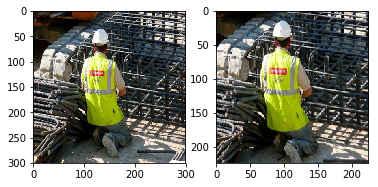

In [20]:
classify_hotdog(deep_dog_net, './train/helmet/101.jpg')


Probabilities are: [  1.60877884e-04   9.99839067e-01]
Helmet


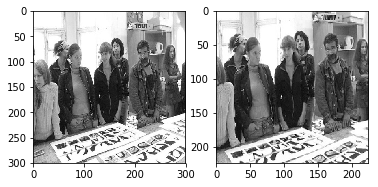

In [22]:
classify_hotdog(deep_dog_net, './train/nohelmet/1403.jpg')


### Reuse class weights
As mentioned earlier, in addition to the feature extractor, we can reuse the class weights for hot dog from the pretrained model, since hot dog was already a class in the imagenet. To do that, we need to get the weight from the classifier layers of the pretrained model, find the right slice, and put it into our two-class classifier.

In [14]:
# let's examine the output layer and find the last conv layer
print(net.output)

HybridSequential(
  (0): Conv2D(512 -> 1000, kernel_size=(1, 1), stride=(1, 1))
  (1): Activation(relu)
  (2): AvgPool2D(size=(13, 13), stride=(13, 13), padding=(0, 0), ceil_mode=False)
  (3): Flatten
)


In [15]:

# the last conv layer is the second layer
pretrained_conv_params = net.output[0].params

# weights can then be found from the above parameter dict
pretrained_weight_param = pretrained_conv_params.get('weight')
pretrained_bias_param = pretrained_conv_params.get('bias')

# next, we locate the right slice that we're interested in.
hotdog_w = mx.nd.split(pretrained_weight_param.data().as_in_context(mx.cpu()),
                       1000, axis=0)[imagenet_hotdog_index]
hotdog_b = mx.nd.split(pretrained_bias_param.data().as_in_context(mx.cpu()),
                       1000, axis=0)[imagenet_hotdog_index]

# our classifier is for two classes. here, we reuse the hotdog class weight,
# and randomly initialize the 'not hotdog' class.
new_classifier_w = mx.nd.concat(mx.nd.random_normal(shape=hotdog_w.shape, scale=0.02),
                                hotdog_w,
                                dim=0)
new_classifier_b = mx.nd.concat(mx.nd.random_normal(shape=hotdog_b.shape, scale=0.02),
                                hotdog_b,
                                dim=0)

# finally, we initialize the parameter buffers and set the values.
# since classifier is a HybridSequential/Sequential, the following
# takes the zero-indexed 1-st layer of the classifier
final_conv_layer_params = deep_dog_net.output[0].params
final_conv_layer_params.get('weight').set_data(new_classifier_w)
final_conv_layer_params.get('bias').set_data(new_classifier_b)

## Evaluation

Our task is a binary classification problem with imbalanced classes. So we'll monitor performance both using accuracy and F1 score, a metric favored in settings with extreme class imbalance.
[Note to authors: ensure that F1 score is explained earlier or explain it here in full]

In [16]:

# return metrics string representation
def metric_str(names, accs):
    return ', '.join(['%s=%f'%(name, acc) for name, acc in zip(names, accs)])
metric = mx.metric.create(['acc', 'f1'])

The following snippet performs inferences on evaluation dataset, and updates the metrics. Once the evaluation data iterator is exhausted, it returns the values of each of the metrics.

In [24]:
import mxnet.gluon as gluon
from mxnet.image import color_normalize

def evaluate(net, data_iter, ctx):
    data_iter.reset()
    for batch in data_iter:
        data = color_normalize(batch.data[0]/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        for x in data:
            outputs.append(net(x))
        metric.update(label, outputs)
    out = metric.get()
    metric.reset()
    return out

## Training

We now can train the model just as we would any supervised model.
In this example, we set up the training loop for multi-GPU use 
as described from first principles [here](../chapter07_distributed-learning/multiple-gpus-scratch.ipynb) and in the context of gluon [here](../chapter07_distributed-learning/multiple-gpus-gluon.ipynb).

In [2]:
import mxnet.autograd as autograd

def train(net, train_iter, val_iter, epochs, ctx):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': wd})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()

    best_f1 = 0
    val_names, val_accs = evaluate(net, val_iter, ctx)
    logging.info('[Initial] validation: %s'%(metric_str(val_names, val_accs)))
    for epoch in range(epochs):
        tic = time.time()
        train_iter.reset()
        btic = time.time()
        for i, batch in enumerate(train_iter):
            # the model zoo models expect normalized images
            data = color_normalize(batch.data[0]/255,
                                   mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                   std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
            label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
            outputs = []
            Ls = []
            with autograd.record():
                for x, y in zip(data, label):
                    z = net(x)
                    # rescale the loss based on class to counter the imbalance problem
                    L = loss(z, y) * (1+y*positive_class_weight)/positive_class_weight
                    # store the loss and do backward after we have done forward
                    # on all GPUs for better speed on multiple GPUs.
                    Ls.append(L)
                    outputs.append(z)
                for L in Ls:
                    L.backward()
            trainer.step(batch.data[0].shape[0])
            metric.update(label, outputs)
            if log_interval and not (i+1)%log_interval:
                names, accs = metric.get()
                logging.info('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(
                               epoch, i, batch_size/(time.time()-btic), metric_str(names, accs)))
            btic = time.time()

        names, accs = metric.get()
        metric.reset()
        logging.info('[Epoch %d] training: %s'%(epoch, metric_str(names, accs)))
        logging.info('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
        val_names, val_accs = evaluate(net, val_iter, ctx)
        logging.info('[Epoch %d] validation: %s'%(epoch, metric_str(val_names, val_accs)))

        if val_accs[1] > best_f1:
            best_f1 = val_accs[1]
            logging.info('Best validation f1 found. Checkpointing...')
            net.save_params('deep-dog-%d.params'%(epoch))

if mode == 'hybrid':
    deep_dog_net.hybridize()
if epochs > 0:
    contexts = [mx.gpu(i) for i in range(gpus)] if gpus > 0 else [mx.cpu()]
    deep_dog_net.collect_params().reset_ctx(contexts)
    train(deep_dog_net, train_iter, val_iter, epochs, contexts)

NameError: name 'deep_dog_net' is not defined

## Try it out!
Once our model is trained, we can either use the `deep_dog_net` model in the notebook kernel, or load it from the best checkpoint.

In [ ]:
# Uncomment below line and replace the file name with the last checkpoint.
# deep_dog_net.load_parameters('deep-dog-3.params', contexts)
#
# Alternatively, you can uncomment the following lines to get the model that we finetuned,
# with validation F1 score of 0.74.
download('https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/deep-dog-5a342a6f.params',
         overwrite=True)
deep_dog_net.load_parameters('deep-dog-5a342a6f.params', contexts)

Probabilities are: [ 0.43714297  0.56285703]
Hotdog!


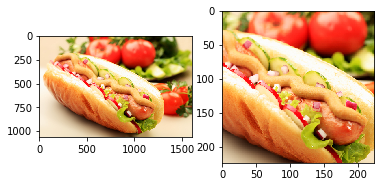

In [20]:
classify_hotdog(deep_dog_net, '../img/real_hotdog.jpg')

Probabilities are: [ 0.59019589  0.40980414]
Not hotdog!


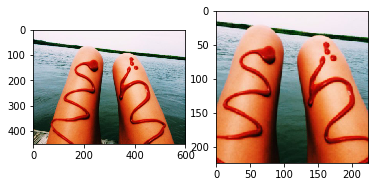

In [21]:
classify_hotdog(deep_dog_net, '../img/leg_hotdog.jpg')

Probabilities are: [ 0.93945837  0.06054162]
Not hotdog!


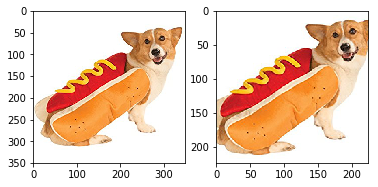

In [22]:
classify_hotdog(deep_dog_net, '../img/dog_hotdog.jpg')

## Conclusions
As you can see, given a pretrained model, we can get a great classifier, 
even for tasks where we simply don't have enough data to train from scratch.
That's because the representations necessary to perform both tasks have a lot in common.
Since they both address natural images, they both require recognizing textures, shapes, edges, etc.
Whenever you have a small enough dataset that you fear impoverishing your model,
try thinking about what larger datasets you might be able to pre-train your model on,
so that you can just perform fine-tuning on the task at hand.


## Next

This section is still changing too fast to say for sure what will come next. Stay tuned!

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)